In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

In [2]:
EPS_INIT = 0.9
EPS_FINAL = 0.01
EPS_DECAY = 3000
GAMMA = 0.99
BUFFER_CAPACITY = 10000
batch_size = 64
TARGET_UPDATE = 5
MAX_EPISODES = 1000
EARLY_STOP_THRESHOLD = 480
EPISODES_EARLY_STOP = 30
NUM_NEURONS = 128

In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        
        self.dense = nn.Sequential(
            nn.Linear(input_shape, NUM_NEURONS),
            nn.ReLU(),
            nn.Linear(NUM_NEURONS, NUM_NEURONS),
            nn.ReLU(),
            nn.Linear(NUM_NEURONS, n_actions)
        )

    def forward(self, x):
        return self.dense(x)

In [5]:
def update():
    batch = replay_buffer.sample(batch_size)

    states, actions, rewards, next_states, dones = batch
    
    # Converti i dati in tensori PyTorch con la giusta forma
    states = torch.FloatTensor(np.array(states)).squeeze(1)  # Rimuove dimensione extra
    actions = torch.LongTensor(np.array(actions)).unsqueeze(1)  # Azioni devono essere 2D (batch_size, 1)
    rewards = torch.FloatTensor(np.array(rewards)).unsqueeze(1)  # Rewards devono essere 2D (batch_size, 1)
    next_states = torch.FloatTensor(np.array(next_states)).squeeze(1)  # Rimuove dimensione extra
    dones = torch.FloatTensor(np.array(dones)).unsqueeze(1)

    # Calcolo dei Q-values
    q_values = model(states).gather(1, actions)  # Seleziona solo il valore Q dell'azione scelta

    # Calcola i Q-values target con la rete target
    with torch.no_grad():
        q_targets = target_model(next_states).max(1, keepdim=True)[0]  # Massimo sulle azioni
    
    y = rewards + GAMMA * q_targets * (1 - dones)  # Formula Bellman

    # Definizione della loss
    loss_fn = nn.MSELoss()
    loss = loss_fn(q_values, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


In [6]:
class ReplayBuffer():
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)

        if len(batch[0]) != 5:
            raise ValueError(f"Expected 5 elements per experience, but got {len(batch[0])}")

        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

In [7]:
def epsilon_greedy_policy(state, steps_done):
    epsilon = EPS_FINAL + (EPS_INIT - EPS_FINAL) * np.exp(-1.0 * steps_done / EPS_DECAY)
    if np.random.rand() < epsilon:
        return np.random.randint(env.action_space.n)
    else:
        q_value = model(state)
        return q_value.argmax(1).item()

In [8]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model.load_state_dict(model.state_dict())
target_model.eval()

replay_buffer = ReplayBuffer(BUFFER_CAPACITY)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [9]:
episode_rewards = []
steps_done = 0
loss_values = []
mean_losses_ep = []

for episode in range(MAX_EPISODES):
    observation, _ = env.reset(seed=SEED)
    state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
    episode_reward = 0

    stop_training = False

    for t in range(1000):   # Max steps per episode of the environment is 500
        action = epsilon_greedy_policy(state, steps_done)
        next_observation,reward, done, truncated, _ = env.step(action)
        next_state = torch.tensor(next_observation, dtype=torch.float32).unsqueeze(0)

        done = done or truncated

        if episode >= EPISODES_EARLY_STOP and np.mean(episode_rewards[-EPISODES_EARLY_STOP:]) > EARLY_STOP_THRESHOLD:    
            print(f"Early stopping at episode {episode}")
            stop_training = True
            break

        replay_buffer.push(state, action, reward, next_state, done)

        episode_reward += reward

        state = next_state
        steps_done += 1

        if len(replay_buffer) > batch_size:
            loss = update()
            loss_values.append(loss)

        if done:
            print(f"Episode {episode} finished after {t+1} timesteps")
            break

    episode_rewards.append(episode_reward)
    mean_loss_ep = np.mean(loss_values)
    mean_losses_ep.append(mean_loss_ep)
    print(f"Episode {episode}, reward: {episode_reward}, mean loss: {mean_loss_ep}")

    if episode % TARGET_UPDATE == 0:
        target_model.load_state_dict(model.state_dict())
        print("Target model updated")
    
    if stop_training:
        break

env.close()

Episode 0 finished after 50 timesteps
Episode 0, reward: 50.0, mean loss: nan
Target model updated
Episode 1 finished after 10 timesteps
Episode 1, reward: 10.0, mean loss: nan
Episode 2 finished after 8 timesteps
Episode 2, reward: 8.0, mean loss: 0.9945642203092575


/Users/edoardozappia/opt/anaconda3/envs/mujoco-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/edoardozappia/opt/anaconda3/envs/mujoco-env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Episode 3 finished after 10 timesteps
Episode 3, reward: 10.0, mean loss: 0.9465151982648032
Episode 4 finished after 26 timesteps
Episode 4, reward: 26.0, mean loss: 0.8331922769546509
Episode 5 finished after 50 timesteps
Episode 5, reward: 50.0, mean loss: 0.6425829857587815
Target model updated
Episode 6 finished after 18 timesteps
Episode 6, reward: 18.0, mean loss: 0.7038324444934174
Episode 7 finished after 14 timesteps
Episode 7, reward: 14.0, mean loss: 0.709373520778828
Episode 8 finished after 16 timesteps
Episode 8, reward: 16.0, mean loss: 0.692002923808236
Episode 9 finished after 15 timesteps
Episode 9, reward: 15.0, mean loss: 0.6628106643561444
Episode 10 finished after 15 timesteps
Episode 10, reward: 15.0, mean loss: 0.6281315920253595
Target model updated
Episode 11 finished after 16 timesteps
Episode 11, reward: 16.0, mean loss: 0.6581867666024229
Episode 12 finished after 20 timesteps
Episode 12, reward: 20.0, mean loss: 0.6554154971358823
Episode 13 finished afte

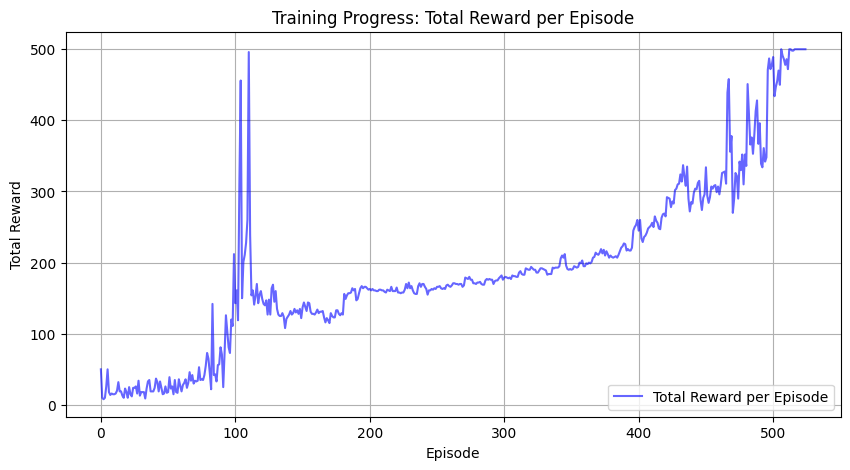

In [10]:
plt.figure(figsize=(10,5))
plt.plot(range(len(episode_rewards)-1), episode_rewards[:-1], label="Total Reward per Episode", color='blue', alpha=0.6)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress: Total Reward per Episode")
plt.legend()
plt.grid(True)
plt.show()

reward_tot 1.0
reward_tot 2.0
reward_tot 3.0
reward_tot 4.0
reward_tot 5.0
reward_tot 6.0
reward_tot 7.0
reward_tot 8.0
reward_tot 9.0
reward_tot 10.0
reward_tot 11.0
reward_tot 12.0
reward_tot 13.0
reward_tot 14.0
reward_tot 15.0
reward_tot 16.0
reward_tot 17.0
reward_tot 18.0
reward_tot 19.0
reward_tot 20.0
reward_tot 21.0
reward_tot 22.0
reward_tot 23.0
reward_tot 24.0
reward_tot 25.0
reward_tot 26.0
reward_tot 27.0
reward_tot 28.0
reward_tot 29.0
reward_tot 30.0
reward_tot 31.0
reward_tot 32.0
reward_tot 33.0
reward_tot 34.0
reward_tot 35.0
reward_tot 36.0
reward_tot 37.0
reward_tot 38.0
reward_tot 39.0
reward_tot 40.0
reward_tot 41.0
reward_tot 42.0
reward_tot 43.0
reward_tot 44.0
reward_tot 45.0
reward_tot 46.0
reward_tot 47.0
reward_tot 48.0
reward_tot 49.0
reward_tot 50.0
reward_tot 51.0
reward_tot 52.0
reward_tot 53.0
reward_tot 54.0
reward_tot 55.0
reward_tot 56.0
reward_tot 57.0
reward_tot 58.0
reward_tot 59.0
reward_tot 60.0
reward_tot 61.0
reward_tot 62.0
reward_tot 63.0
r

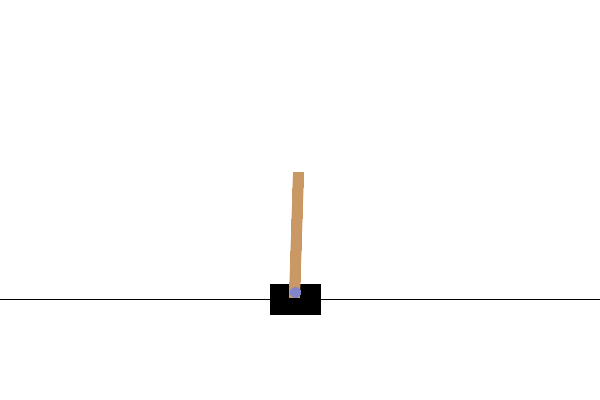

In [12]:
import gym
import torch
import imageio
import numpy as np
import matplotlib.pyplot as plt

def test_agent_and_create_gif(model, env, filename="cartpole_dqn_test.gif"):
    reward_tot = 0
    frames = []
    observation, _ = env.reset()
    state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
    
    done = False
    while not done:
        # Usa il modello per selezionare l'azione migliore (greedy)
        with torch.no_grad():
            action = model(state).argmax(dim=1).item()
        
        # Esegui l'azione e salva il frame
        next_observation, reward, done, truncated, _ = env.step(action)
        frames.append(env.render())  # Salva il frame
        
        state = torch.tensor(next_observation, dtype=torch.float32).unsqueeze(0)

        reward_tot += reward

        print(f"reward_tot {reward_tot}")

        if truncated:
            break
    
    env.close()

    # Salva la GIF
    imageio.mimsave(filename, frames, fps=30)
    print(f"GIF salvata come {filename}")

    # Mostra la GIF nel notebook
    from IPython.display import display, Image
    display(Image(filename=filename))

# Testa l'agente e genera la GIF
test_agent_and_create_gif(model, env)
